In [1]:
import pandas as pd
import numpy as np
import statistics
import sklearn.metrics
import warnings
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import os
warnings.filterwarnings("ignore")

In [2]:
def get_accuracy(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    num_correct_ann= annotation_df[annotation_df[correct_id_col]==annotation_df[predicted_id_col]].shape[0]
    acc=num_correct_ann/annotation_df.shape[0]
    return acc

In [3]:
def get_balanced_accuracy_verbose(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    ann=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        cell_type_sub = annotation_df[annotation_df[correct_id_col]==cell_type]
        print(cell_type)
        num_cells =cell_type_sub.shape[0]
        print("predicted cell ID")
        num_correct_ann = cell_type_sub[cell_type_sub[predicted_id_col]==cell_type].shape[0]
        #print(cell_type_sub.predicted_cellID.value_counts())
        perc=(num_correct_ann/num_cells)
        print(perc)
        ann.append(perc)
    balanced_accuracy= np.sum(ann)/len(ann)
    print("balanced accuracy:")
    print(balanced_accuracy)
    return balanced_accuracy

In [4]:
def get_balanced_accuracy(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    ann=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        cell_type_sub = annotation_df[annotation_df[correct_id_col]==cell_type]
        num_cells =cell_type_sub.shape[0]
        num_correct_ann = cell_type_sub[cell_type_sub[predicted_id_col]==cell_type].shape[0]
        #print(cell_type_sub.predicted_cellID.value_counts())
        perc=(num_correct_ann/num_cells)
        ann.append(perc)
    balanced_accuracy= np.sum(ann)/len(ann)
    return balanced_accuracy

In [5]:
def get_cluster_accuracy(annotation_df, cluster_id_column ='clust',correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    correc_ann_counter=0
    annotation_df = annotation_df.groupby(cluster_id_column).filter(lambda x: len(x) > 10)
    cluster_ids =sorted(set(annotation_df[cluster_id_column]))
    for cluster_id in cluster_ids:
        cluster_sub = annotation_df[annotation_df[cluster_id_column]==cluster_id]   
        clust_real_id_counts = cluster_sub[correct_id_col].value_counts()
        # sort fist by number then by index, then get the cell type with the highest occurance. This takes care of ties
        clust_real_id = clust_real_id_counts.iloc[np.lexsort((clust_real_id_counts.index, -clust_real_id_counts.values))].index[0]
        clust_predicted_id_counts = cluster_sub[predicted_id_col].value_counts()
        # sort fist by number then by index, then get the cell type with the highest occurance. This takes care of ties
        clust_predicted_id = clust_predicted_id_counts.iloc[np.lexsort((clust_predicted_id_counts.index, -clust_predicted_id_counts.values))].index[0]
        if clust_real_id == clust_predicted_id:
            correc_ann_counter += 1
        else:
            continue
    clust_accuracy= correc_ann_counter/len(cluster_ids)
    return clust_accuracy

In [6]:
def get_cohens_kappa_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    cohens_kappa_score= sklearn.metrics.cohen_kappa_score(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(cohens_kappa_score)

In [7]:
def get_F1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    F1_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest 
        # then convert df labels to binary classification tasks
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        #cell_type_sub = cell_type_sub[[correct_id_col, predicted_id_col]]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        F1_cell_type = sklearn.metrics.f1_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        F1_list.append(F1_cell_type)
    return(F1_list)

In [8]:
def get_macroF1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID', label_list=None):
    if label_list ==None:
        label_list  = annotation_df[correct_id_col].value_counts().index   
    macroF1_score = sklearn.metrics.f1_score(annotation_df[correct_id_col], annotation_df[predicted_id_col],average='macro', labels=label_list)
    return(macroF1_score)


In [9]:
def get_medianF1_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    F1_scores = get_F1_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianF1_score = statistics.median(F1_scores)
    return(medianF1_score)

In [10]:
def get_precision_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    precision_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        precision_cell_type = sklearn.metrics.precision_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        precision_list.append(precision_cell_type)
    return(precision_list)

In [11]:
def get_medianPrecision_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    precision_scores = get_precision_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianPrecision_score = statistics.median(precision_scores)
    return(medianPrecision_score)

In [12]:
def get_recall_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    recall_list=[]
    for cell_type in sorted(set(annotation_df[correct_id_col])):
        # subset dataframe to the cell-type of interest
        cell_type_sub = annotation_df[(annotation_df[correct_id_col]==cell_type) | (annotation_df[predicted_id_col]==cell_type)]
        cell_type_sub[correct_id_col] = cell_type_sub[correct_id_col].where(cell_type_sub[correct_id_col].isin([cell_type]), 'other')
        cell_type_sub[predicted_id_col] = cell_type_sub[predicted_id_col].where(cell_type_sub[predicted_id_col].isin([cell_type]), 'other')
        recall_cell_type = sklearn.metrics.recall_score(cell_type_sub[correct_id_col], cell_type_sub[predicted_id_col], pos_label = cell_type)
        recall_list.append(recall_cell_type)
    return(recall_list)

In [13]:
def get_medianRecall_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    recall_scores = get_recall_score(annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
    medianPrecision_score = statistics.median(recall_scores)
    return(medianPrecision_score)

In [14]:
def get_adjusted_rand_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    adjusted_rand_score= sklearn.metrics.adjusted_rand_score(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(adjusted_rand_score)

In [15]:
def get_mathews_corr_coef_score(annotation_df, correct_id_col='real_cellID', predicted_id_col='predicted_cellID'):
    matthews_corrcoef_score= sklearn.metrics.matthews_corrcoef(annotation_df[correct_id_col],annotation_df[predicted_id_col])
    return(matthews_corrcoef_score)

In [16]:
def get_common_cells(*dataframes):
    df_cell_list = [v.index for v in dataframes]
    common_cells= list(set.intersection(*map(set,df_cell_list)))
    return(common_cells)

In [17]:
def get_combined_annotations_df_for_common_cells(*frames, common_cells, cell_ID_column = "cell_IDs"):
    if not frames:
        return None
    if len(frames) == 1:
        return frames[0]
    out = frames[0]
    out = out.loc[common_cells,]
    for df in frames[1:]:
        out = out.merge(df.loc[common_cells,], on=cell_ID_column)
    return out

In [18]:
def plot_performance_metrics(df , colors=None, labels = None, y_min = 0.0, frame_color = 'gray', frame_width = 0.5, x_label_rotation = 45, tick_size = 14,legend_fontsize = 12,
                            legend_labels = None, legend_loc = 'upper center', legend_bbox_to_anchor=(0.5, -0.2), legend_ncol=4, save=False, save_path=None):

    # Default values
    default_colors = ['#5E0B8A', '#00A7E1', '#BDDA57', '#FF8C00']
    default_labels = ['accuracy', 'balanced \naccuracy','cluster \naccuracy', 'macro \nF1', 'median \nF1',
                      'median \nprecision', 'median \nrecall','MCC', 'ARI', "Cohen's \nkappa"]
    default_legend_labels =['scATAcat', 'Seurat label transfer', 'Cellcano', 'EpiAnno']

    # Use default if None is passed
    colors = default_colors if colors is None else colors
    labels = default_labels if labels is None else labels
    legend_labels = default_legend_labels if legend_labels is None else legend_labels
  
    df.columns = labels
    df.index = legend_labels
    
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42

    n_bins = 100  # Increase this number for a smoother gradient
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=n_bins)
    ax = df.T.plot(kind='bar', figsize=(15, 10), legend=True, fontsize=12, colormap=cmap)
    ax.set_ylim(ymin=y_min)
    # Change plot frame to gray and adjust linewidth
    spine_color = 'gray'
    linewidth = frame_width # Adjust the linewidth as needed
    for spine in ax.spines.values():
        spine.set_color(spine_color)
        spine.set_linewidth(linewidth)
    ax.legend(legend_labels,fontsize=legend_fontsize, loc=legend_loc, bbox_to_anchor=legend_bbox_to_anchor,
          fancybox=False, shadow=False, ncol=legend_ncol, frameon=False)
    plt.xticks(rotation=x_label_rotation)
    plt.tick_params(axis='both', which='major', labelsize=tick_size)

    if save == False:
        plt.show()
    else:
        if save_path == None:
            print("specify the save_path directory")
        else:
            plt.savefig(save_path, bbox_inches='tight', transparent=True)

In [19]:
NeurIPS_BM_s1d1_metadata = pd.read_csv("../../../../scATAcat_notebooks_for_paper/jan2024/data/NeurIPS_BM_scmultiome/03_cell_IDs/NeurIPS_BM_s1d1_metadata.csv", index_col=0)

In [20]:
NeurIPS_BM_s1d1_metadata["cellIDs"] = NeurIPS_BM_s1d1_metadata.index.str.split("-").str[:-1].str.join('-')

In [21]:
NeurIPS_BM_s1d1_metadata[["cellIDs", "cell_type"]]

,cellIDs,cell_type
TAGTTGTCACCCTCAC-1-s1d1,TAGTTGTCACCCTCAC-1,Naive CD20+ B
CTATGGCCATAACGGG-1-s1d1,CTATGGCCATAACGGG-1,CD14+ Mono
CCGCACACAGGTTAAA-1-s1d1,CCGCACACAGGTTAAA-1,CD8+ T
TCATTTGGTAATGGAA-1-s1d1,TCATTTGGTAATGGAA-1,CD8+ T
ACCACATAGGTGTCCA-1-s1d1,ACCACATAGGTGTCCA-1,CD16+ Mono
...,...,...
AGACCCGGTTATCCTA-1-s1d1,AGACCCGGTTATCCTA-1,CD4+ T activated
GACCTAAGTGCCTCAC-1-s1d1,GACCTAAGTGCCTCAC-1,pDC
AGCTCATAGCTATATG-1-s1d1,AGCTCATAGCTATATG-1,CD4+ T activated
TACGTACAGGAAACTG-1-s1d1,TACGTACAGGAAACTG-1,CD4+ T naive


In [22]:
NeurIPS_BM_s1d1_metadata.index = NeurIPS_BM_s1d1_metadata.cellIDs

In [23]:
NeurIPS_BM_s1d1_metadata = NeurIPS_BM_s1d1_metadata[["cellIDs", "cell_type"]]

In [24]:
NeurIPS_ann_rename_dict = {'B1 B': 'Bcell',
 'CD14+ Mono': 'Mono',
 'CD16+ Mono': 'Mono',
 'CD4+ T activated':"CD4Tcell",
 'CD4+ T naive':"CD4Tcell",
 'CD8+ T':"CD8Tcell",
 'Erythroblast':"Ery",
 'G/M prog':"GMP",
 'HSC':"HSC",
 'ID2-hi myeloid prog':"CMP",
 'ILC':"ILC",
 'Lymph prog':"CLP",
 'MK/E prog':"MEP",
 'NK':"NKcell",
 'Naive CD20+ B':"Bcell",
 'Normoblast':"Ery", #
 'Plasma cell':"Plasma cell",
 'Proerythroblast':"Ery",
 'Transitional B':"Bcell",
 'cDC2':"cDC2",
 'pDC':'pDC'}

In [25]:
NeurIPS_BM_s1d1_metadata['NeurIPS_ann_simp'] =list(NeurIPS_BM_s1d1_metadata["cell_type"].map(NeurIPS_ann_rename_dict))
NeurIPS_BM_s1d1_metadata.index.name = None
NeurIPS_BM_s1d1_metadata.columns=["cell_IDs", "ground_truth_annotations","ground_truth_annotations_simplified" ]
NeurIPS_BM_s1d1_metadata

,cell_IDs,ground_truth_annotations,ground_truth_annotations_simplified
TAGTTGTCACCCTCAC-1,TAGTTGTCACCCTCAC-1,Naive CD20+ B,Bcell
CTATGGCCATAACGGG-1,CTATGGCCATAACGGG-1,CD14+ Mono,Mono
CCGCACACAGGTTAAA-1,CCGCACACAGGTTAAA-1,CD8+ T,CD8Tcell
TCATTTGGTAATGGAA-1,TCATTTGGTAATGGAA-1,CD8+ T,CD8Tcell
ACCACATAGGTGTCCA-1,ACCACATAGGTGTCCA-1,CD16+ Mono,Mono
...,...,...,...
AGACCCGGTTATCCTA-1,AGACCCGGTTATCCTA-1,CD4+ T activated,CD4Tcell
GACCTAAGTGCCTCAC-1,GACCTAAGTGCCTCAC-1,pDC,pDC
AGCTCATAGCTATATG-1,AGCTCATAGCTATATG-1,CD4+ T activated,CD4Tcell
TACGTACAGGAAACTG-1,TACGTACAGGAAACTG-1,CD4+ T naive,CD4Tcell


### seurat annotations

In [26]:
seurat_labelTransfer_annotations = pd.read_csv("/project/scATAC_analysis/NeurIPS2021_BM_scmultiome/analysis/04_annotate_via_Seurat3_label_transfer/outs/bm_neurips_labelTransfer_predicted_annotations.csv", index_col = 0)
seurat_labelTransfer_annotations.head()

,predicted.celltype.l2,cellID
AAACAGCCAATTAAGG-1,CD4 Naive,AAACAGCCAATTAAGG-1
AAACAGCCAGGCTGTT-1,Prog_B 1,AAACAGCCAGGCTGTT-1
AAACATGCAAAGCGCA-1,CD4 Memory,AAACATGCAAAGCGCA-1
AAACATGCAATAACCT-1,Prog_RBC,AAACATGCAATAACCT-1
AAACATGCAATAATGG-1,CD8 Memory_2,AAACATGCAATAATGG-1


In [27]:
seurat_annotations = ['CD4 Naive', 'Prog_B 1', 'CD4 Memory', 'Prog_RBC', 'CD8 Memory_2', 'Memory B', 'NK', 'CD14 Mono', 'CD8 Naive', 'CD8 Effector_2', 'Naive B', 'HSC', 'MAIT', 'pDC', 'GMP', 'CD16 Mono', 'gdT', 'Prog_B 2', 'LMPP', 'CD8 Effector_1', 'Prog_DC', 'Plasmablast', 'cDC2', 'Prog_Mk', 'CD56 bright NK', 'CD8 Memory_1']
seurat_annotations_simplified = ['CD4Tcell', "CLP", 'CD4Tcell', "MEP", "CD8Tcell", "Bcell", "NKcell", "Mono", "CD8Tcell", "CD8Tcell", "Bcell", 'HSC', 'MAIT', 'pDC', 'GMP', "Mono", 'gdT', 'CLP', 'LMPP', 'CD8Tcell', "CMP", 'Plasmablast', 'cDC2', "MEP", "NKcell", 'CD8Tcell']

seurat_annotations_and_simplified_dict = dict(zip(seurat_annotations, seurat_annotations_simplified))

print(seurat_annotations_and_simplified_dict)


{'CD4 Naive': 'CD4Tcell', 'Prog_B 1': 'CLP', 'CD4 Memory': 'CD4Tcell', 'Prog_RBC': 'MEP', 'CD8 Memory_2': 'CD8Tcell', 'Memory B': 'Bcell', 'NK': 'NKcell', 'CD14 Mono': 'Mono', 'CD8 Naive': 'CD8Tcell', 'CD8 Effector_2': 'CD8Tcell', 'Naive B': 'Bcell', 'HSC': 'HSC', 'MAIT': 'MAIT', 'pDC': 'pDC', 'GMP': 'GMP', 'CD16 Mono': 'Mono', 'gdT': 'gdT', 'Prog_B 2': 'CLP', 'LMPP': 'LMPP', 'CD8 Effector_1': 'CD8Tcell', 'Prog_DC': 'CMP', 'Plasmablast': 'Plasmablast', 'cDC2': 'cDC2', 'Prog_Mk': 'MEP', 'CD56 bright NK': 'NKcell', 'CD8 Memory_1': 'CD8Tcell'}


In [28]:
seurat_labelTransfer_annotations['seurat_annotations_simp'] =list(seurat_labelTransfer_annotations["predicted.celltype.l2"].map(seurat_annotations_and_simplified_dict))
seurat_labelTransfer_annotations.columns=["label_transfer_annotations", "cell_IDs", "label_transfer_annotations_simplified"]

In [29]:
seurat_labelTransfer_annotations

,label_transfer_annotations,cell_IDs,label_transfer_annotations_simplified
AAACAGCCAATTAAGG-1,CD4 Naive,AAACAGCCAATTAAGG-1,CD4Tcell
AAACAGCCAGGCTGTT-1,Prog_B 1,AAACAGCCAGGCTGTT-1,CLP
AAACATGCAAAGCGCA-1,CD4 Memory,AAACATGCAAAGCGCA-1,CD4Tcell
AAACATGCAATAACCT-1,Prog_RBC,AAACATGCAATAACCT-1,MEP
AAACATGCAATAATGG-1,CD8 Memory_2,AAACATGCAATAATGG-1,CD8Tcell
...,...,...,...
TTTGTGTTCATTTGCT-1,CD4 Naive,TTTGTGTTCATTTGCT-1,CD4Tcell
TTTGTGTTCGACCTGA-1,Prog_RBC,TTTGTGTTCGACCTGA-1,MEP
TTTGTGTTCGCCTAAG-1,CD4 Naive,TTTGTGTTCGCCTAAG-1,CD4Tcell
TTTGTTGGTACGGTAC-1,CD4 Naive,TTTGTTGGTACGGTAC-1,CD4Tcell


### scATAcat annotations

In [30]:
scATAcat_annotations = pd.read_csv("../../../results/Fig5_SFig3-NeurIPS_BM_scmultiome/Fig5_SFig3-apply_scATAcat/outputs_pairwise_feature_selection/scATAcat_annotations.csv", index_col=0 )
scATAcat_annotations.index.name = None
scATAcat_annotations.columns = ['leiden_1.0', 'scATAcat_annotation','cell_IDs']
scATAcat_annotations

,leiden_1.0,scATAcat_annotation,cell_IDs
TAGTTGTCACCCTCAC-1,4,Bcell,TAGTTGTCACCCTCAC-1
CTATGGCCATAACGGG-1,0,Mono,CTATGGCCATAACGGG-1
CCGCACACAGGTTAAA-1,6,CD8Tcell,CCGCACACAGGTTAAA-1
TCATTTGGTAATGGAA-1,3,CD8Tcell,TCATTTGGTAATGGAA-1
ACCACATAGGTGTCCA-1,0,Mono,ACCACATAGGTGTCCA-1
...,...,...,...
AGACCCGGTTATCCTA-1,1,CD4Tcell,AGACCCGGTTATCCTA-1
GACCTAAGTGCCTCAC-1,12,pDC,GACCTAAGTGCCTCAC-1
AGCTCATAGCTATATG-1,6,CD8Tcell,AGCTCATAGCTATATG-1
TACGTACAGGAAACTG-1,5,CD4Tcell,TACGTACAGGAAACTG-1


In [31]:
scATAcat_annotations.scATAcat_annotation.value_counts()

scATAcat_annotation
CD4Tcell    1175
Ery         1151
Mono        1012
CD8Tcell     988
Bcell        760
NKcell       572
GMP          289
pDC           90
Name: count, dtype: int64

### Cellcano annotations

In [32]:
Cellcano_annotations = pd.read_csv("../../../results/Fig5_SFig3-NeurIPS_BM_scmultiome/Fig5-apply_Cellcano/output_NeurIPS2021/predict_NeurIPS2021celltypes.csv")

In [33]:
Cellcano_annotations.head()

,Unnamed: 0,pred_celltype,firstround_pred_celltype,entropy
0,NeurIPS2021_s1d1_fragments_no_chrMt.sort.bed.#...,Pre-B,pDC,2.349120
1,NeurIPS2021_s1d1_fragments_no_chrMt.sort.bed.#...,N-CD8T2,N-CD8T2,1.377121
2,NeurIPS2021_s1d1_fragments_no_chrMt.sort.bed.#...,Plasma-B,Plasma-B,2.272312
3,NeurIPS2021_s1d1_fragments_no_chrMt.sort.bed.#...,HSC/MPP,Mono1,2.823547
4,NeurIPS2021_s1d1_fragments_no_chrMt.sort.bed.#...,Mono1,pDC,1.833082


In [34]:
Cellcano_annotations[['prefix', 'cell_IDs']] = Cellcano_annotations.iloc[:,0].str.split("#", n=1, expand=True)
Cellcano_annotations = Cellcano_annotations[["cell_IDs", "pred_celltype"]]
Cellcano_annotations.columns = ["cell_IDs", "Cellcano_annotations"]
Cellcano_annotations.index =Cellcano_annotations["cell_IDs"]
Cellcano_annotations.index.name = None
Cellcano_annotations.head()

,cell_IDs,Cellcano_annotations
TACGTAATCATGCCTC-1,TACGTAATCATGCCTC-1,Pre-B
GGAACCTGTACAATGT-1,GGAACCTGTACAATGT-1,N-CD8T2
ATTTGTGAGTAGCGGG-1,ATTTGTGAGTAGCGGG-1,Plasma-B
GACGCAACAAGCCAGA-1,GACGCAACAAGCCAGA-1,HSC/MPP
TTGGCTTGTAGGTGTC-1,TTGGCTTGTAGGTGTC-1,Mono1


In [35]:
Cellcano_annotations.Cellcano_annotations.value_counts()

Cellcano_annotations
N-CD8T2     1939
MEP         1238
Mono2       1176
EM-CDT8      978
Mat-NK2      874
Naive-B      512
Pre-B        305
Memory-B     273
Plasma-B     225
HSC/MPP      210
MDP          208
Mono1        203
pDC           75
GDelta-T      38
cDC           34
LMPP          13
CM-CD8T       12
M-CD4T         5
Pro-B          3
GMP            1
Name: count, dtype: int64

In [36]:
Cellcano_annotations_ = ['HSC/MPP','MEP','CMP/BMP','LMPP','CLP','Pro-B','Pre-B','GMP','MDP','pDC','cDC','Mono1','Mono2','Naive-B','Memory-B','Plasma-B','Basofil','Imm-NK','Mat-NK1','Mat-NK2','N-CD4T1','N-CD4T2','N-Treg','M-CD4T','Treg','N-CD8T1','N-CD8T2','N-CD8T3','CM-CD8T','EM-CDT8','GDelta-T']
Cellcano_annotations_simplified  =['HSC/MPP','MEP','CMP','LMPP','CLP','CLP','CLP','GMP','GMP','pDC','cDC','Mono','Mono','Bcell','Bcell','Bcell','Basofil','NKcell','NKcell','NKcell','CD4Tcell','CD4Tcell','Treg','CD4Tcell','Treg','CD8Tcell','CD8Tcell','CD8Tcell','CD8Tcell','CD8Tcell','gdT']
Cellcano_annotations_simplified_dict = dict(zip(Cellcano_annotations_, Cellcano_annotations_simplified))

print(Cellcano_annotations_simplified_dict)

{'HSC/MPP': 'HSC/MPP', 'MEP': 'MEP', 'CMP/BMP': 'CMP', 'LMPP': 'LMPP', 'CLP': 'CLP', 'Pro-B': 'CLP', 'Pre-B': 'CLP', 'GMP': 'GMP', 'MDP': 'GMP', 'pDC': 'pDC', 'cDC': 'cDC', 'Mono1': 'Mono', 'Mono2': 'Mono', 'Naive-B': 'Bcell', 'Memory-B': 'Bcell', 'Plasma-B': 'Bcell', 'Basofil': 'Basofil', 'Imm-NK': 'NKcell', 'Mat-NK1': 'NKcell', 'Mat-NK2': 'NKcell', 'N-CD4T1': 'CD4Tcell', 'N-CD4T2': 'CD4Tcell', 'N-Treg': 'Treg', 'M-CD4T': 'CD4Tcell', 'Treg': 'Treg', 'N-CD8T1': 'CD8Tcell', 'N-CD8T2': 'CD8Tcell', 'N-CD8T3': 'CD8Tcell', 'CM-CD8T': 'CD8Tcell', 'EM-CDT8': 'CD8Tcell', 'GDelta-T': 'gdT'}


In [37]:

Cellcano_annotations= Cellcano_annotations.assign(Cellcano_annotations_simplified=list(Cellcano_annotations['Cellcano_annotations'].map(Cellcano_annotations_simplified_dict)))
Cellcano_annotations.head()

,cell_IDs,Cellcano_annotations,Cellcano_annotations_simplified
TACGTAATCATGCCTC-1,TACGTAATCATGCCTC-1,Pre-B,CLP
GGAACCTGTACAATGT-1,GGAACCTGTACAATGT-1,N-CD8T2,CD8Tcell
ATTTGTGAGTAGCGGG-1,ATTTGTGAGTAGCGGG-1,Plasma-B,Bcell
GACGCAACAAGCCAGA-1,GACGCAACAAGCCAGA-1,HSC/MPP,HSC/MPP
TTGGCTTGTAGGTGTC-1,TTGGCTTGTAGGTGTC-1,Mono1,Mono


### EpiAnno annotations

In [38]:
EpiAnno_annotations = pd.read_csv("../../../results/Fig5_SFig3-NeurIPS_BM_scmultiome/Fig5-apply_EpiAnno/SatpathyBM_with_NeurIPS_BM_peaks/predicted_labels.csv", index_col=0)
EpiAnno_annotations.columns = ["cell_IDs", "EpiAnno_annotations"]
EpiAnno_annotations.index =EpiAnno_annotations["cell_IDs"]
EpiAnno_annotations.index.name = None


In [39]:
EpiAnno_annotations.head()

,cell_IDs,EpiAnno_annotations
TACGTAATCATGCCTC-1,TACGTAATCATGCCTC-1,HSC/MPP
GGAACCTGTACAATGT-1,GGAACCTGTACAATGT-1,CMP/BMP
ATTTGTGAGTAGCGGG-1,ATTTGTGAGTAGCGGG-1,HSC/MPP
GACGCAACAAGCCAGA-1,GACGCAACAAGCCAGA-1,HSC/MPP
TTGGCTTGTAGGTGTC-1,TTGGCTTGTAGGTGTC-1,HSC/MPP


In [40]:
EpiAnno_annotations_ = ['HSC/MPP','MEP','CMP/BMP','LMPP','CLP','Pro-B','Pre-B','GMP','MDP','pDC','cDC','Mono1','Mono2','Naive-B','Memory-B','Plasma-B','Basofil','Imm-NK','Mat-NK1','Mat-NK2','N-CD4T1','N-CD4T2','N-Treg','M-CD4T','Treg','N-CD8T1','N-CD8T2','N-CD8T3','CM-CD8T','EM-CDT8','GDelta-T']
EpiAnno_annotations_simplified  =[ "HSC/MPP","MEP","CMP","LMPP","CLP","CLP","CLP","GMP","GMP","pDC","cDC","Mono","Mono","Bcell","Bcell","Bcell","Basofil","NKcell","NKcell","NKcell","CD4Tcell","CD4Tcell","Treg","CD4Tcell","Treg","CD8Tcell","CD8Tcell","CD8Tcell","CD8Tcell","CD8Tcell","gdT"]
EpiAnno_annotations_simplified_dict = dict(zip(EpiAnno_annotations_, EpiAnno_annotations_simplified))

print(EpiAnno_annotations_simplified_dict)

{'HSC/MPP': 'HSC/MPP', 'MEP': 'MEP', 'CMP/BMP': 'CMP', 'LMPP': 'LMPP', 'CLP': 'CLP', 'Pro-B': 'CLP', 'Pre-B': 'CLP', 'GMP': 'GMP', 'MDP': 'GMP', 'pDC': 'pDC', 'cDC': 'cDC', 'Mono1': 'Mono', 'Mono2': 'Mono', 'Naive-B': 'Bcell', 'Memory-B': 'Bcell', 'Plasma-B': 'Bcell', 'Basofil': 'Basofil', 'Imm-NK': 'NKcell', 'Mat-NK1': 'NKcell', 'Mat-NK2': 'NKcell', 'N-CD4T1': 'CD4Tcell', 'N-CD4T2': 'CD4Tcell', 'N-Treg': 'Treg', 'M-CD4T': 'CD4Tcell', 'Treg': 'Treg', 'N-CD8T1': 'CD8Tcell', 'N-CD8T2': 'CD8Tcell', 'N-CD8T3': 'CD8Tcell', 'CM-CD8T': 'CD8Tcell', 'EM-CDT8': 'CD8Tcell', 'GDelta-T': 'gdT'}


In [41]:

EpiAnno_annotations= EpiAnno_annotations.assign(EpiAnno_annotations_simplified=list(EpiAnno_annotations['EpiAnno_annotations'].map(EpiAnno_annotations_simplified_dict)))
EpiAnno_annotations.head()

,cell_IDs,EpiAnno_annotations,EpiAnno_annotations_simplified
TACGTAATCATGCCTC-1,TACGTAATCATGCCTC-1,HSC/MPP,HSC/MPP
GGAACCTGTACAATGT-1,GGAACCTGTACAATGT-1,CMP/BMP,CMP
ATTTGTGAGTAGCGGG-1,ATTTGTGAGTAGCGGG-1,HSC/MPP,HSC/MPP
GACGCAACAAGCCAGA-1,GACGCAACAAGCCAGA-1,HSC/MPP,HSC/MPP
TTGGCTTGTAGGTGTC-1,TTGGCTTGTAGGTGTC-1,HSC/MPP,HSC/MPP


## combine the annotations for the common cells:



In [42]:
EpiAnno_annotations

,cell_IDs,EpiAnno_annotations,EpiAnno_annotations_simplified
TACGTAATCATGCCTC-1,TACGTAATCATGCCTC-1,HSC/MPP,HSC/MPP
GGAACCTGTACAATGT-1,GGAACCTGTACAATGT-1,CMP/BMP,CMP
ATTTGTGAGTAGCGGG-1,ATTTGTGAGTAGCGGG-1,HSC/MPP,HSC/MPP
GACGCAACAAGCCAGA-1,GACGCAACAAGCCAGA-1,HSC/MPP,HSC/MPP
TTGGCTTGTAGGTGTC-1,TTGGCTTGTAGGTGTC-1,HSC/MPP,HSC/MPP
...,...,...,...
GATTTGCAGTTTGGTA-1,GATTTGCAGTTTGGTA-1,CMP/BMP,CMP
AGGCAATCACTAAATC-1,AGGCAATCACTAAATC-1,CMP/BMP,CMP
GGTACAAAGAGAGGCT-1,GGTACAAAGAGAGGCT-1,CMP/BMP,CMP
GGTCAAGCAGCCTTGG-1,GGTCAAGCAGCCTTGG-1,HSC/MPP,HSC/MPP


In [43]:
EpiAnno_annotations.EpiAnno_annotations_simplified.value_counts()

EpiAnno_annotations_simplified
HSC/MPP     6009
CMP         2185
CD8Tcell     119
MEP            4
CLP            3
CD4Tcell       1
Mono           1
Name: count, dtype: int64

In [44]:
common_cells = get_common_cells(scATAcat_annotations, seurat_labelTransfer_annotations,Cellcano_annotations, EpiAnno_annotations, NeurIPS_BM_s1d1_metadata)

In [45]:
pd.DataFrame(common_cells).to_csv("../../../results/Fig5_SFig3-NeurIPS_BM_scmultiome/compare_annotation_performances/commonCells.csv",index=False)

In [46]:
all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(scATAcat_annotations, seurat_labelTransfer_annotations,Cellcano_annotations, EpiAnno_annotations,NeurIPS_BM_s1d1_metadata, common_cells=common_cells, cell_ID_column = "cell_IDs")

In [47]:
all_methods_for_commonCells.columns

Index(['leiden_1.0', 'scATAcat_annotation', 'cell_IDs',
       'label_transfer_annotations', 'label_transfer_annotations_simplified',
       'Cellcano_annotations', 'Cellcano_annotations_simplified',
       'EpiAnno_annotations', 'EpiAnno_annotations_simplified',
       'ground_truth_annotations', 'ground_truth_annotations_simplified'],
      dtype='object')

In [48]:
all_methods_for_commonCells.ground_truth_annotations_simplified.value_counts()

ground_truth_annotations_simplified
CD4Tcell       1324
Ery            1070
Mono            940
CD8Tcell        680
Bcell           658
NKcell          568
GMP             106
pDC              89
MEP              64
Plasma cell      59
ILC              59
CLP              52
HSC              39
cDC2             36
CMP              22
Name: count, dtype: int64

In [49]:
all_methods_for_commonCells.scATAcat_annotation.value_counts()

scATAcat_annotation
CD4Tcell    1141
Ery         1074
Mono         963
CD8Tcell     932
Bcell        749
NKcell       530
GMP          287
pDC           90
Name: count, dtype: int64

In [50]:
all_methods_for_commonCells.label_transfer_annotations_simplified.value_counts()

label_transfer_annotations_simplified
CD4Tcell       1142
MEP            1018
Mono            956
NKcell          671
Bcell           633
CD8Tcell        564
GMP             131
MAIT            129
CLP             128
HSC              81
Plasmablast      72
pDC              69
gdT              61
LMPP             48
cDC2             40
CMP              23
Name: count, dtype: int64

In [51]:
all_methods_for_commonCells.Cellcano_annotations_simplified.value_counts()

Cellcano_annotations_simplified
CD8Tcell    2030
MEP         1032
Mono         919
Bcell        621
NKcell       577
CLP          186
HSC/MPP      184
GMP          117
pDC           39
gdT           24
cDC           22
LMPP          11
CD4Tcell       4
Name: count, dtype: int64

In [52]:
all_methods_for_commonCells.EpiAnno_annotations_simplified.value_counts()

EpiAnno_annotations_simplified
HSC/MPP     4224
CMP         1526
CD8Tcell      16
Name: count, dtype: int64

## subset the ground truth to common annotations


In [53]:
common_annotations = list(set(all_methods_for_commonCells.scATAcat_annotation)
                          &set(all_methods_for_commonCells.ground_truth_annotations_simplified)
                          &set(all_methods_for_commonCells.label_transfer_annotations_simplified)
                          &set(all_methods_for_commonCells.Cellcano_annotations_simplified)
                          &set(all_methods_for_commonCells.EpiAnno_annotations_simplified))
common_annotations

['CD8Tcell']

In [54]:
common_annotations_witho_EpiAnno = list(set(all_methods_for_commonCells.scATAcat_annotation)
                          &set(all_methods_for_commonCells.ground_truth_annotations_simplified)
                          &set(all_methods_for_commonCells.label_transfer_annotations_simplified)
                          &set(all_methods_for_commonCells.Cellcano_annotations_simplified))
common_annotations_witho_EpiAnno

['NKcell', 'Bcell', 'pDC', 'CD4Tcell', 'Mono', 'GMP', 'CD8Tcell']

In [55]:
set(all_methods_for_commonCells.scATAcat_annotation)

{'Bcell', 'CD4Tcell', 'CD8Tcell', 'Ery', 'GMP', 'Mono', 'NKcell', 'pDC'}

In [56]:
set(all_methods_for_commonCells.ground_truth_annotations_simplified)

{'Bcell',
 'CD4Tcell',
 'CD8Tcell',
 'CLP',
 'CMP',
 'Ery',
 'GMP',
 'HSC',
 'ILC',
 'MEP',
 'Mono',
 'NKcell',
 'Plasma cell',
 'cDC2',
 'pDC'}

In [57]:
set(all_methods_for_commonCells.label_transfer_annotations_simplified)

{'Bcell',
 'CD4Tcell',
 'CD8Tcell',
 'CLP',
 'CMP',
 'GMP',
 'HSC',
 'LMPP',
 'MAIT',
 'MEP',
 'Mono',
 'NKcell',
 'Plasmablast',
 'cDC2',
 'gdT',
 'pDC'}

In [58]:
common_annotations

['CD8Tcell']

In [59]:
all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]

In [60]:
all_methods_for_commonCells_commonAnnotations

,leiden_1.0,scATAcat_annotation,cell_IDs,label_transfer_annotations,label_transfer_annotations_simplified,Cellcano_annotations,Cellcano_annotations_simplified,EpiAnno_annotations,EpiAnno_annotations_simplified,ground_truth_annotations,ground_truth_annotations_simplified
9,3,CD8Tcell,GAAGGCCCATAGCGAG-1,CD8 Memory_2,CD8Tcell,EM-CDT8,CD8Tcell,HSC/MPP,HSC/MPP,CD8+ T,CD8Tcell
13,6,CD8Tcell,AGCTTAATCGCTTCTA-1,CD8 Memory_2,CD8Tcell,EM-CDT8,CD8Tcell,CMP/BMP,CMP,CD8+ T,CD8Tcell
18,3,CD8Tcell,CTTACTAGTCCTTCTC-1,NK,NKcell,EM-CDT8,CD8Tcell,HSC/MPP,HSC/MPP,CD8+ T,CD8Tcell
21,6,CD8Tcell,ACCCTCCCAATTGCGC-1,CD8 Memory_2,CD8Tcell,EM-CDT8,CD8Tcell,HSC/MPP,HSC/MPP,CD8+ T,CD8Tcell
38,3,CD8Tcell,ACCAATATCTGGTCCT-1,CD8 Memory_2,CD8Tcell,EM-CDT8,CD8Tcell,HSC/MPP,HSC/MPP,CD8+ T,CD8Tcell
...,...,...,...,...,...,...,...,...,...,...,...
5680,3,CD8Tcell,AATTACCCAGGTTATT-1,MAIT,MAIT,EM-CDT8,CD8Tcell,CMP/BMP,CMP,CD8+ T,CD8Tcell
5697,3,CD8Tcell,ATCAAGACATAAGTCT-1,CD8 Effector_2,CD8Tcell,EM-CDT8,CD8Tcell,HSC/MPP,HSC/MPP,CD8+ T,CD8Tcell
5698,3,CD8Tcell,AACCGGCTCGTGCTTC-1,CD8 Effector_2,CD8Tcell,EM-CDT8,CD8Tcell,CMP/BMP,CMP,CD8+ T,CD8Tcell
5706,6,CD8Tcell,GCACATTAGTTTGGTA-1,CD4 Memory,CD4Tcell,GDelta-T,gdT,HSC/MPP,HSC/MPP,CD8+ T,CD8Tcell


In [61]:
all_methods_for_commonCells_commonAnnotations.columns

Index(['leiden_1.0', 'scATAcat_annotation', 'cell_IDs',
       'label_transfer_annotations', 'label_transfer_annotations_simplified',
       'Cellcano_annotations', 'Cellcano_annotations_simplified',
       'EpiAnno_annotations', 'EpiAnno_annotations_simplified',
       'ground_truth_annotations', 'ground_truth_annotations_simplified'],
      dtype='object')

## scores only for common cells and common annotations 

In [62]:
all_methods_for_commonCells_commonAnnotations

,leiden_1.0,scATAcat_annotation,cell_IDs,label_transfer_annotations,label_transfer_annotations_simplified,Cellcano_annotations,Cellcano_annotations_simplified,EpiAnno_annotations,EpiAnno_annotations_simplified,ground_truth_annotations,ground_truth_annotations_simplified
9,3,CD8Tcell,GAAGGCCCATAGCGAG-1,CD8 Memory_2,CD8Tcell,EM-CDT8,CD8Tcell,HSC/MPP,HSC/MPP,CD8+ T,CD8Tcell
13,6,CD8Tcell,AGCTTAATCGCTTCTA-1,CD8 Memory_2,CD8Tcell,EM-CDT8,CD8Tcell,CMP/BMP,CMP,CD8+ T,CD8Tcell
18,3,CD8Tcell,CTTACTAGTCCTTCTC-1,NK,NKcell,EM-CDT8,CD8Tcell,HSC/MPP,HSC/MPP,CD8+ T,CD8Tcell
21,6,CD8Tcell,ACCCTCCCAATTGCGC-1,CD8 Memory_2,CD8Tcell,EM-CDT8,CD8Tcell,HSC/MPP,HSC/MPP,CD8+ T,CD8Tcell
38,3,CD8Tcell,ACCAATATCTGGTCCT-1,CD8 Memory_2,CD8Tcell,EM-CDT8,CD8Tcell,HSC/MPP,HSC/MPP,CD8+ T,CD8Tcell
...,...,...,...,...,...,...,...,...,...,...,...
5680,3,CD8Tcell,AATTACCCAGGTTATT-1,MAIT,MAIT,EM-CDT8,CD8Tcell,CMP/BMP,CMP,CD8+ T,CD8Tcell
5697,3,CD8Tcell,ATCAAGACATAAGTCT-1,CD8 Effector_2,CD8Tcell,EM-CDT8,CD8Tcell,HSC/MPP,HSC/MPP,CD8+ T,CD8Tcell
5698,3,CD8Tcell,AACCGGCTCGTGCTTC-1,CD8 Effector_2,CD8Tcell,EM-CDT8,CD8Tcell,CMP/BMP,CMP,CD8+ T,CD8Tcell
5706,6,CD8Tcell,GCACATTAGTTTGGTA-1,CD4 Memory,CD4Tcell,GDelta-T,gdT,HSC/MPP,HSC/MPP,CD8+ T,CD8Tcell


In [63]:
scores_df = pd.DataFrame(index=["scATAcat", "Seurat_label_transfer", "Cellcano", "EpiAnno"],
                        columns=["accuracy","balanced_accuracy","cluster_accuracy","macroF1_score","medianF1_score","medianPrecision_score","medianRecall_score","mathews_corr_coef_score","adjusted_rand_score","cohens_kappa_score"])
annotation_df = all_methods_for_commonCells_commonAnnotations
correct_id_col = 'ground_truth_annotations_simplified'
cluster_id_column ='leiden_1.0'
for method in scores_df.index:
    if method == "scATAcat":
        predicted_id_col = "scATAcat_annotation"
        scores_df.loc["scATAcat", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["scATAcat", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Seurat_label_transfer":
        predicted_id_col = "label_transfer_annotations_simplified"
        scores_df.loc["Seurat_label_transfer", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Seurat_label_transfer", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Cellcano":
        predicted_id_col = "Cellcano_annotations_simplified"
        scores_df.loc["Cellcano", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Cellcano", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "EpiAnno":
        predicted_id_col = "EpiAnno_annotations_simplified"
        scores_df.loc["EpiAnno", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["EpiAnno", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)


In [64]:
scores_df

,accuracy,balanced_accuracy,cluster_accuracy,macroF1_score,medianF1_score,medianPrecision_score,medianRecall_score,mathews_corr_coef_score,adjusted_rand_score,cohens_kappa_score
scATAcat,0.989706,0.989706,1.0,0.994826,0.994826,1.0,0.989706,0.0,0.0,0.0
Seurat_label_transfer,0.533824,0.533824,1.0,0.696069,0.696069,1.0,0.533824,0.0,0.0,0.0
Cellcano,0.954412,0.954412,1.0,0.976674,0.976674,1.0,0.954412,0.0,0.0,0.0
EpiAnno,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
figures_dir = "../../../results/Fig5_SFig3-NeurIPS_BM_scmultiome/compare_annotation_performances/figures/"

In [66]:
import os
os.makedirs(figures_dir,exist_ok=True)

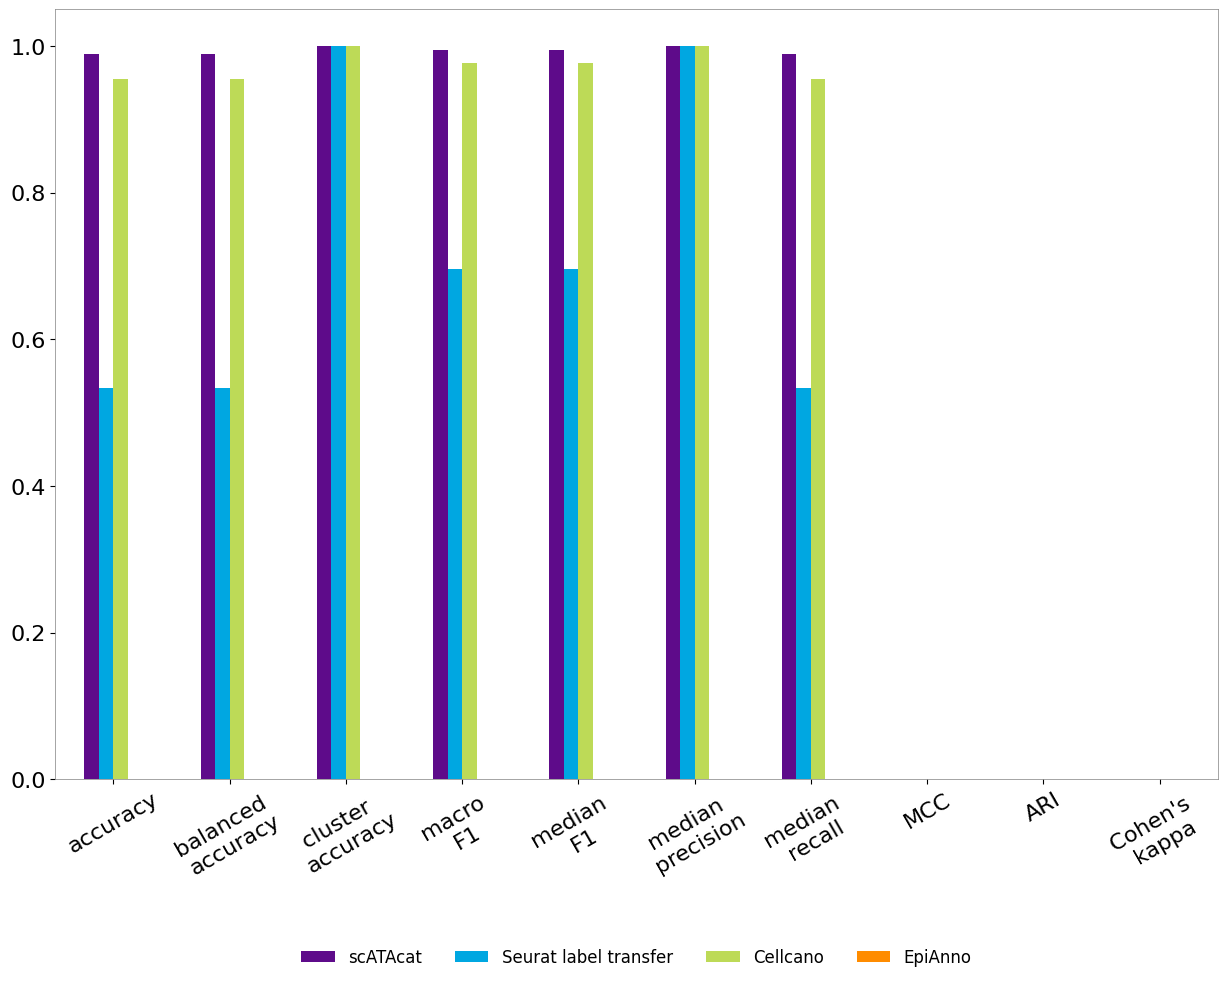

In [67]:
plot_performance_metrics(df = scores_df, save=True, tick_size=16, legend_fontsize=12, save_path=figures_dir+ '/common_cells_common_annotations.png', x_label_rotation=30 )

## scores for common cells & common annoations without EpiAnno

In [68]:
all_methods_witho_EpiAnno_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations_witho_EpiAnno)]

In [69]:
scores_df = pd.DataFrame(index=["scATAcat", "Seurat_label_transfer", "Cellcano"],
                        columns=["accuracy","balanced_accuracy","cluster_accuracy","macroF1_score","medianF1_score","medianPrecision_score","medianRecall_score","mathews_corr_coef_score","adjusted_rand_score","cohens_kappa_score"])
common_cells = get_common_cells(scATAcat_annotations, seurat_labelTransfer_annotations,Cellcano_annotations, EpiAnno_annotations, NeurIPS_BM_s1d1_metadata)
all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(scATAcat_annotations, seurat_labelTransfer_annotations,Cellcano_annotations, EpiAnno_annotations,NeurIPS_BM_s1d1_metadata, common_cells=common_cells, cell_ID_column = "cell_IDs")
common_annotations_witho_EpiAnno = list(set(all_methods_for_commonCells.scATAcat_annotation)
                          &set(all_methods_for_commonCells.ground_truth_annotations_simplified)
                          &set(all_methods_for_commonCells.label_transfer_annotations_simplified)
                          &set(all_methods_for_commonCells.Cellcano_annotations_simplified))
all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations_witho_EpiAnno)]
annotation_df = all_methods_witho_EpiAnno_for_commonCells_commonAnnotations
correct_id_col = 'ground_truth_annotations_simplified'
cluster_id_column ='leiden_1.0'
for method in scores_df.index:
    if method == "scATAcat":
        predicted_id_col = "scATAcat_annotation"
        scores_df.loc["scATAcat", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["scATAcat", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Seurat_label_transfer":
        predicted_id_col = "label_transfer_annotations_simplified"
        scores_df.loc["Seurat_label_transfer", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Seurat_label_transfer", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Cellcano":
        predicted_id_col = "Cellcano_annotations_simplified"
        scores_df.loc["Cellcano", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Cellcano", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)

In [70]:
scores_df

,accuracy,balanced_accuracy,cluster_accuracy,macroF1_score,medianF1_score,medianPrecision_score,medianRecall_score,mathews_corr_coef_score,adjusted_rand_score,cohens_kappa_score
scATAcat,0.922795,0.911205,1.0,0.888567,0.920016,0.978852,0.924528,0.906913,0.836986,0.904007
Seurat_label_transfer,0.785109,0.719097,0.7,0.753623,0.873418,0.908602,0.775281,0.739517,0.665942,0.737063
Cellcano,0.613058,0.625014,0.6,0.600643,0.59375,0.980565,0.843465,0.611772,0.671779,0.543763


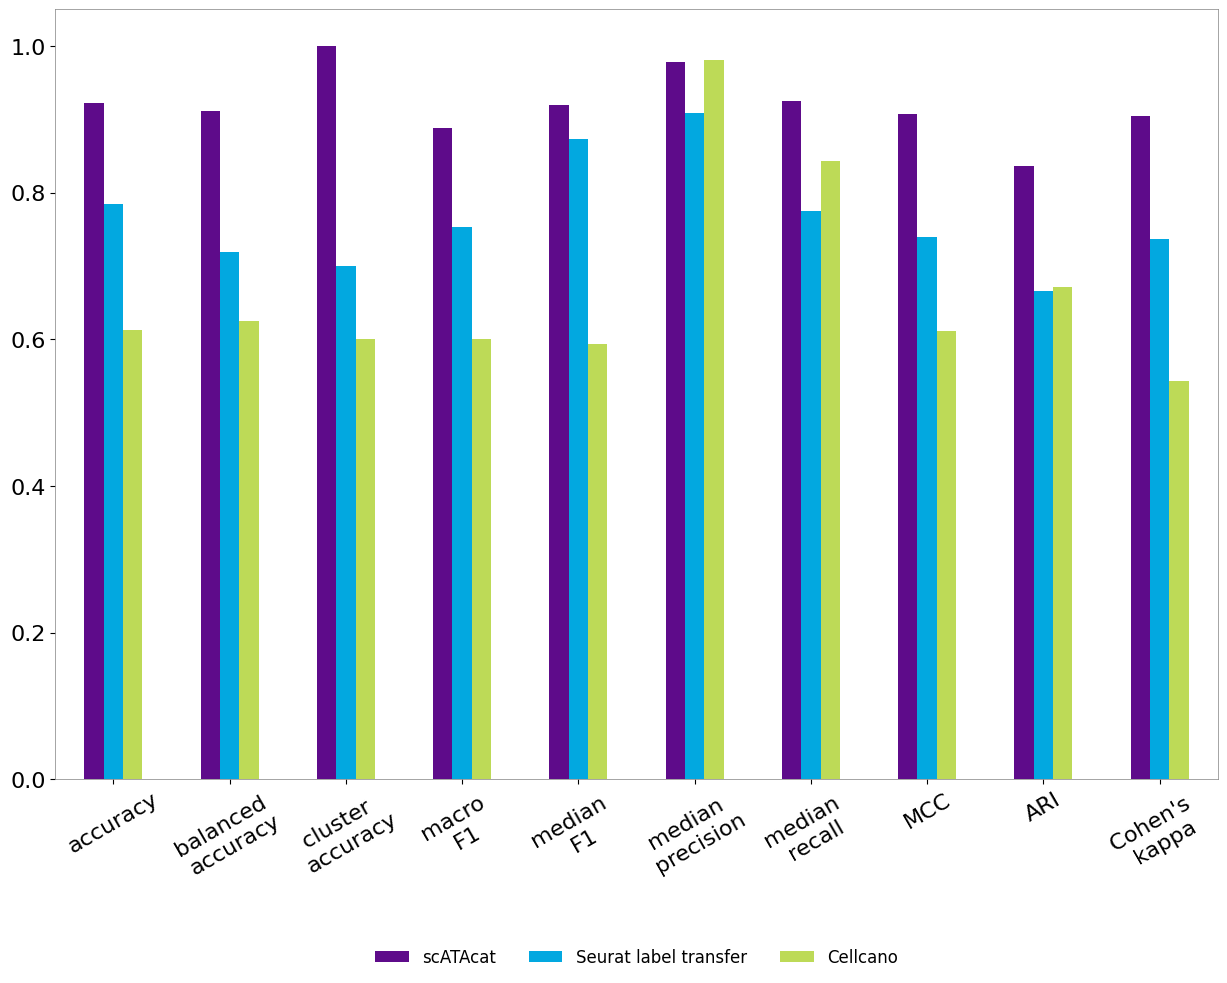

In [71]:
plot_performance_metrics(df = scores_df, colors=['#5E0B8A', '#00A7E1', '#BDDA57'],
                         save=True, tick_size=16, legend_fontsize=12, save_path=figures_dir+ '/common_cells_common_annotations_wtho_EpiAnno.png', legend_labels=['scATAcat', 'Seurat label transfer', 'Cellcano'],
                         x_label_rotation=30)

## scores for common cells & pairwise common annotations


In [74]:
scores_df = pd.DataFrame(index=["scATAcat", "Seurat_label_transfer", "Cellcano", "EpiAnno"],
                        columns=["accuracy","balanced_accuracy","macroF1_score","medianF1_score","medianPrecision_score","medianRecall_score","mathews_corr_coef_score","adjusted_rand_score","cohens_kappa_score"])
common_cells = get_common_cells(scATAcat_annotations, seurat_labelTransfer_annotations,Cellcano_annotations, EpiAnno_annotations, NeurIPS_BM_s1d1_metadata)
all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(scATAcat_annotations, seurat_labelTransfer_annotations,Cellcano_annotations, EpiAnno_annotations,NeurIPS_BM_s1d1_metadata, common_cells=common_cells, cell_ID_column = "cell_IDs")
# annotation_df = all_methods_for_commonCells
correct_id_col = 'ground_truth_annotations_simplified'
cluster_id_column ='leiden_1.0'
for method in scores_df.index:
    if method == "scATAcat":
        # common_cells = get_common_cells(scATAcat_annotations,NeurIPS_BM_s1d1_metadata)
        # all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(scATAcat_annotations,NeurIPS_BM_s1d1_metadata, common_cells=common_cells, cell_ID_column = "cell_IDs")
        common_annotations = list(set(all_methods_for_commonCells.scATAcat_annotation)
                                  &set(all_methods_for_commonCells.ground_truth_annotations_simplified))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations
        predicted_id_col = "scATAcat_annotation"
        scores_df.loc["scATAcat", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["scATAcat", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["scATAcat", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Seurat_label_transfer":
        # common_cells = get_common_cells(seurat_labelTransfer_annotations,NeurIPS_BM_s1d1_metadata)
        # all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(seurat_labelTransfer_annotations,NeurIPS_BM_s1d1_metadata, common_cells=common_cells, cell_ID_column = "cell_IDs")
        common_annotations = list(set(all_methods_for_commonCells.label_transfer_annotations)
                                  &set(all_methods_for_commonCells.ground_truth_annotations_simplified))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations        
        predicted_id_col = "label_transfer_annotations"
        scores_df.loc["Seurat_label_transfer", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Seurat_label_transfer", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Seurat_label_transfer", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "Cellcano":
        # common_cells = get_common_cells(Cellcano_annotations,NeurIPS_BM_s1d1_metadata)
        # all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(Cellcano_annotations,NeurIPS_BM_s1d1_metadata, common_cells=common_cells, cell_ID_column = "cell_IDs")
        common_annotations = list(set(all_methods_for_commonCells.Cellcano_annotations_simplified)
                                  &set(all_methods_for_commonCells.ground_truth_annotations_simplified))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations
        predicted_id_col = "Cellcano_annotations_simplified"
        scores_df.loc["Cellcano", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["Cellcano", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["Cellcano", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
    if method == "EpiAnno":
        # common_cells = get_common_cells(EpiAnno_annotations,NeurIPS_BM_s1d1_metadata)
        # all_methods_for_commonCells = get_combined_annotations_df_for_common_cells(EpiAnno_annotations,NeurIPS_BM_s1d1_metadata, common_cells=common_cells, cell_ID_column = "cell_IDs")
        common_annotations = list(set(all_methods_for_commonCells.EpiAnno_annotations_simplified)
                                  &set(all_methods_for_commonCells.ground_truth_annotations_simplified))
        all_methods_for_commonCells_commonAnnotations = all_methods_for_commonCells[all_methods_for_commonCells.ground_truth_annotations_simplified.isin(common_annotations)]
        annotation_df = all_methods_for_commonCells_commonAnnotations
        predicted_id_col = "EpiAnno_annotations_simplified"
        scores_df.loc["EpiAnno", "accuracy"] = get_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "balanced_accuracy"] = get_balanced_accuracy(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cluster_accuracy"] =  get_cluster_accuracy(annotation_df = annotation_df, cluster_id_column =cluster_id_column,correct_id_col=correct_id_col, predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "macroF1_score"] = get_macroF1_score(annotation_df = annotation_df, correct_id_col=correct_id_col, predicted_id_col=predicted_id_col, label_list=None)
        scores_df.loc["EpiAnno", "medianF1_score"] = get_medianF1_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianPrecision_score"] = get_medianPrecision_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "medianRecall_score"] =  get_medianRecall_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "mathews_corr_coef_score"] = get_mathews_corr_coef_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "adjusted_rand_score"] = get_adjusted_rand_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)
        scores_df.loc["EpiAnno", "cohens_kappa_score"] =  get_cohens_kappa_score(annotation_df = annotation_df,correct_id_col=correct_id_col,predicted_id_col=predicted_id_col)


In [75]:
scores_df

,accuracy,balanced_accuracy,macroF1_score,medianF1_score,medianPrecision_score,medianRecall_score,mathews_corr_coef_score,adjusted_rand_score,cohens_kappa_score,cluster_accuracy
scATAcat,0.937259,0.921837,0.901224,0.922709,0.986792,0.949498,0.926699,0.877406,0.924858,1.00
Seurat_label_transfer,0.6,0.699585,0.704636,0.775594,0.966667,0.776529,0.561958,0.459667,0.51493,0.75
Cellcano,0.606561,0.575865,0.506277,0.482169,0.974359,0.807692,0.603395,0.673631,0.539992,0.60
EpiAnno,0.014245,0.227273,0.063291,0.063291,0.036765,0.227273,0.059349,0.057446,0.008224,0.00


In [76]:
common_annotations

['CMP', 'CD8Tcell']

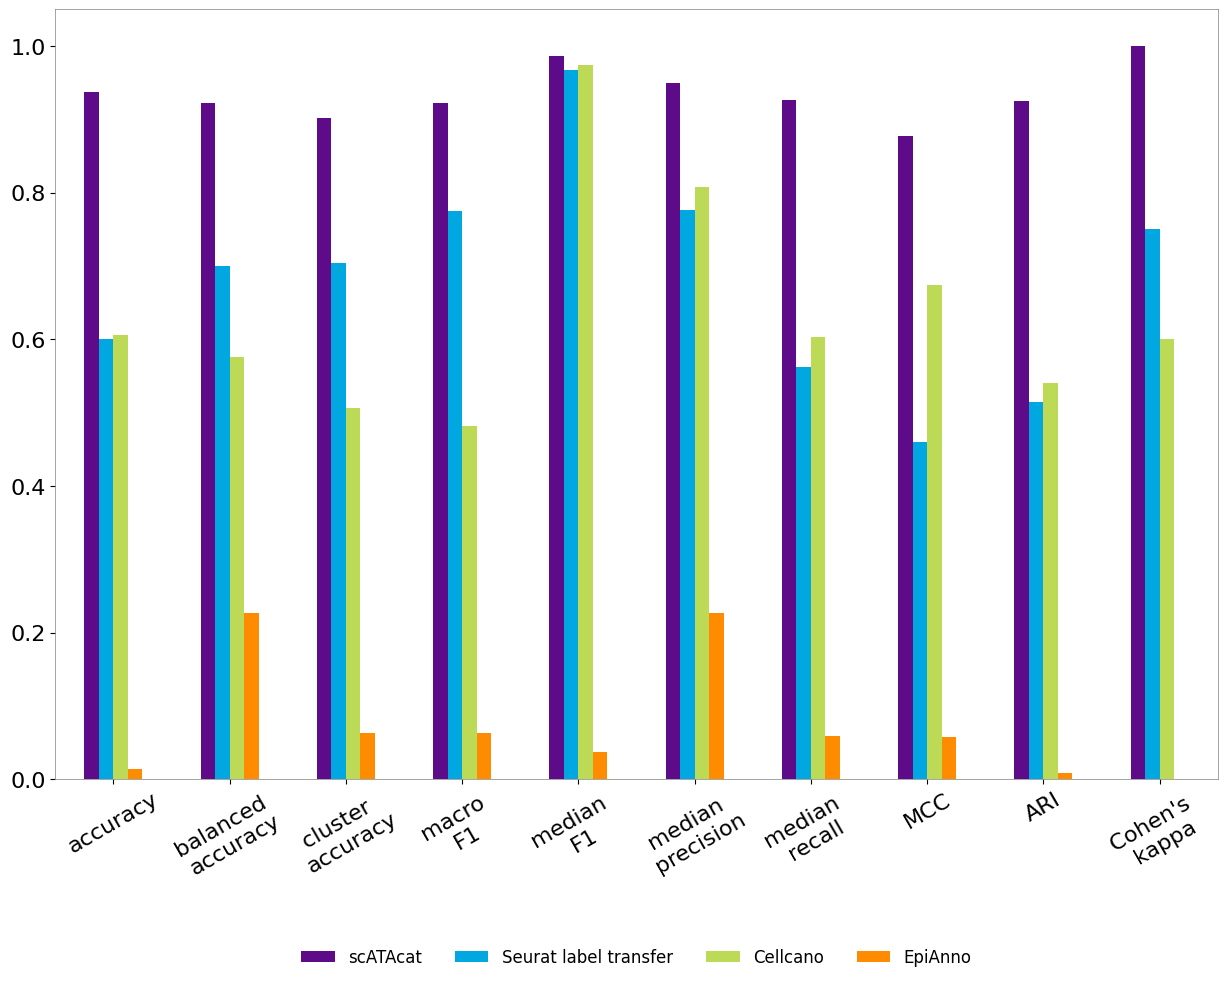

In [77]:
plot_performance_metrics(df = scores_df, save=True, tick_size=16, legend_fontsize=12, save_path=figures_dir+ '/common_cells_pairwise_common_annotations.png',x_label_rotation=30)